# 第六週: 英文文集的情緒分析2

**Author:** 劉岱宜<br>
**Date created:** 2021/10/01<br>
**Last modified:** 2021/10/01<br>
本週課程為「情緒分析2」，與情緒分析1不同，這次會使用corenlp自然語言處理工具包，此包含 Courpus-base 的情緒分析，不是使用情緒字典而是使用預訓練的情緒分析模型或演算法為整個文章給與一個情緒分數。情緒分析2的步驟會因所要分析之語言不同而有所差異，在這個Jupyter Notebook當中將會展示「英文」的情緒分析，並且搭配python程式碼進行講解。在後面的內容中會介紹coreNLP、分析方法、介紹一款用於情緒分析的套件TextBlob

## 大綱
1. 套件說明
2. coreNLP 介紹
    + 2.1 安裝coreNLP
    + 2.2 利用coreNLP進行自然語言處理
    + 2.3 利用coreNLP進行句法結構標註
3. 文章抓取 & coreNLP 標註
    + 3.1 用twitter api抓取資料
    + 3.2 將抓取結果用coreNLP進行處理
    + 3.3 探索分析 - NER
    + 3.4 探索分析 - Sentiment
4. TextBlob

## 分析目標
分析主題：2021-09-15 到 2021-09-20　期間，推特上各國對於covid 19的新聞大事件
藉由本次的分析，希望可以回答以下問題：

1. 推特上討論疫苗的國家/組織/名人主要有哪些，發生了甚麼重要事件？
    + 討論章節：3.3 
        + NER 抓出特定實體
        + 查看相關推文、關鍵字
2. 推特上討論疫苗文章情緒分布的趨勢如何，正面和負面的文章主要的討論焦點?
    + 討論章節：3.4 
        + 情緒分析推測文章中句子的正負情緒
        + 文字雲、關鍵字找出相關討論事件

## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- stanza: 使用CoreNLP的官方套件
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- textblob: TextBlob是一個用Python編寫的開源的文字處理庫。它可以用來執行很多自然語言處理的任務，比如，詞性標註，名詞性成分提取，情緒分析，文字翻譯

In [ ]:
# 安裝會使用到的套件
# %pip install stanza ipywidgets wordcloud tweepy textblob

In [1]:
# 確認當前工作目錄
%pwd

'/home/skypc785308/SMA_2021F/week6_sentiment_analysis2'

In [2]:
import stanza
from stanza.server import CoreNLPClient
from ipywidgets import IntProgress

import os
import time
import pandas as pd

import tweepy as tw

from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import *
from nltk.corpus import stopwords

from wordcloud import WordCloud, STOPWORDS

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## 2. coreNLP 介紹
Stanford CoreNLP是Stanford大學NLP Group用Java開發的NLP工具，它支持很多中語言(包括中文)。整合了許多工具來實現斷詞、斷句、詞性標註、句法分析等許多常見的NLP任務。

### 2.1 安裝coreNLP
+ 可以用stanza管理NLP的相關模型

In [6]:
stanza.install_corenlp("./stanza_corenlp") # 下載coreNLP模型，預設會在/stanza_corenlp裡面

2021-11-02 00:42:46 INFO: Installing CoreNLP package into ./stanza_corenlp...


2021-11-02 00:44:23 WARNING: For customized installation location, please set the `CORENLP_HOME` environment variable to the location of the installation. In Unix, this is done with `export CORENLP_HOME=./stanza_corenlp`.


In [7]:
os.environ['CORENLP_HOME'] = "./stanza_corenlp" # 因為自訂下載路徑，所以要設定環境參數

### 開啟CoreNLP client 端

+ 每次使用CoreNLP套件就需要開啟Client
+ 可以設定相關的port和處理的memory大小
+ 記得每次開起來之後要把client關掉，可以用with語法確保每次執行完自己關掉
+ 不然會因為重複使用 port 出現`Error: unable to start the CoreNLP server on port XXX`的錯誤訊息
    
以下用簡單的範例說明

In [8]:
# 設定 CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9000
client = CoreNLPClient(
             # client要處理的項目
            annotators=['tokenize','ssplit','pos','lemma','ner', 'parse', 'depparse','coref', 'sentiment'],     
            memory='4G', 
            endpoint='http://localhost:9008',
            be_quiet=True
        )

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(5)

2021-11-02 00:44:35 INFO: Writing properties to tmp file: corenlp_server-f06f8d218a5c4671.props
2021-11-02 00:44:35 INFO: Starting server with command: java -Xmx4G -cp ./stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9008 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f06f8d218a5c4671.props -annotators tokenize,ssplit,pos,lemma,ner,parse,depparse,coref -preload -outputFormat serialized


In [9]:
# 將要分析的字串傳入client，得到coreNLP的document object
text = 'A blog post using Stanford CoreNLP Server. Visit www.khalidalnajjar.com for more details.'
document = client.annotate(text)
print(type(document))

<class 'CoreNLP_pb2.Document'>


### 2.2 利用coreNLP進行自然語言處理
透過幾行code就可以實現斷詞、詞性標註、詞型還原、命名實體辨識

本次教材主要會用到的功能有以下幾個
+ [lemma](https://stanfordnlp.github.io/CoreNLP/lemma.html)：詞性還原，將字詞還原成原始的時態，如`was`還原成`be`
+ [POS](https://stanfordnlp.github.io/CoreNLP/pos.html)：詞性標註，標註字詞的詞性，如名詞、動詞等等
    ([coreNLP doc](https://nlp.stanford.edu/software/tagger.shtml)、[Penn Treebank POS Tag Set](https://www.eecis.udel.edu/~vijay/cis889/ie/pos-set.pdf))
+ [NER](https://stanfordnlp.github.io/CoreNLP/ner.html)：命名實體辨識，可以識別句子中的實體，如人名、地名、組織名稱等等

In [10]:
# text 會被分成個句子，用for迴圈把每個字取出來，看看對應的 lemma, pos and ner tags 標籤
print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")  
    
for i, sent in enumerate(document.sentence): 
    for t in sent.token:
        print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
    print("")

Word        	Lemma       	POS   	NER
A           	a           	DT    	O
blog        	blog        	NN    	O
post        	post        	NN    	O
using       	use         	VBG   	O
Stanford    	Stanford    	NNP   	O
CoreNLP     	corenlp     	NN    	O
Server      	server      	NN    	O
.           	.           	.     	O

Visit       	visit       	VB    	O
www.khalidalnajjar.com	www.khalidalnajjar.com	ADD   	URL
for         	for         	IN    	O
more        	more        	JJR   	O
details     	detail      	NNS   	O
.           	.           	.     	O



### 2.3  利用coreNLP進行句法結構標註(Dependency)

In [11]:
# 示範句法結構
for i, sent in enumerate(document.sentence):
    
    # get the constituency parse of the sentence
    constituency_parse = sent.parseTree # child 
    print(constituency_parse)

    # get the dependency parse of the first sentence
    dependency_parse = sent.basicDependencies # edge
    print(dependency_parse)
    break # 只顯示第一句!!

child {
  child {
    child {
      child {
        value: "A"
      }
      value: "DT"
      score: -4.670736789703369
    }
    child {
      child {
        value: "blog"
      }
      value: "NN"
      score: -9.66670036315918
    }
    child {
      child {
        value: "post"
      }
      value: "NN"
      score: -7.835064888000488
    }
    value: "NP"
    score: -26.095684051513672
  }
  child {
    child {
      child {
        value: "using"
      }
      value: "VBG"
      score: -3.688901901245117
    }
    child {
      child {
        child {
          value: "Stanford"
        }
        value: "NNP"
        score: -9.325450897216797
      }
      child {
        child {
          value: "CoreNLP"
        }
        value: "NN"
        score: -16.279035568237305
      }
      child {
        child {
          value: "Server"
        }
        value: "NN"
        score: -12.386455535888672
      }
      value: "NP"
      score: -47.03589630126953
    }
    value: "VP"
 

### Dependency 視覺化
+ 官網範例: https://corenlp.run/

剛剛我們已經透過`stanza`套件將coreNLP服務起動，服務開在`localhost:9008`，我們可以透過`from nltk.parse import CoreNLPParser`將Dependency進行較佳的視覺化。
或者我們可以使用terminal下指令手動把coreNLP服務啟動
1. cd 透過stanza套件下載corenlp模型的資料夾 `./stanza_corenlp`
2. 用java指令把CoreNL服務打開<br/>`java -mx1g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9010 -timeout 15000`

In [12]:
parser = CoreNLPParser('http://localhost:9008') # 使用開在loclahost:9008的coreNLP服務
text = 'A blog post using Stanford CoreNLP Server. Visit www.khalidalnajjar.com for more details.'
parser.raw_parse(text)

fox_parsed = next(parser.raw_parse(text))
fox_parsed.pretty_print()

                                          ROOT                                                     
                                           |                                                        
                                           S                                                       
                 __________________________|_____________________________________________________   
                S                                |                          S                    | 
                |                                |                          |                    |  
                NP                               |                          VP                   | 
      __________|_____________                   |     _____________________|___                 |  
     |                        VP                 |    |          |              PP               | 
     |           _____________|_____             |    |          |           ___|____           

### 2.4 利用coreNLP進行情緒標註(Sentiment)

In [13]:

document = client.annotate("I love this cheese sandwich, it’s so delicious. This chicken burger has a very bad taste")
print(f"{'Word':12s}\t{'Sentiment':12s}") 
for i, sent in enumerate(document.sentence):
    for t in sent.token:
        print("{:12s}\t{:12s}".format(t.word,t.sentiment))
    print(f"The sentiment of the {i}-th sentence is {sent.sentiment}\n")

Word        	Sentiment   
I           	Neutral     
love        	Very positive
this        	Neutral     
cheese      	Neutral     
sandwich    	Neutral     
,           	Neutral     
it          	Neutral     
’s          	Neutral     
so          	Neutral     
delicious   	Positive    
.           	Neutral     
The sentiment of the 0-th sentence is Positive

This        	Neutral     
chicken     	Neutral     
burger      	Neutral     
has         	Neutral     
a           	Neutral     
very        	Neutral     
bad         	Very negative
taste       	Neutral     
The sentiment of the 1-th sentence is Very negative



In [40]:
# 最後再把背景的client關掉
client.stop()
time.sleep(5)
!ps -o pid,cmd | grep java

 2765 /bin/bash -c ps -o pid,cmd | grep java
 2767 grep java


## 3. 文章抓取 & coreNLP 標註
### 3.1 用twitter api抓取資料
資料來源:
+ twitter api 爬取貼文
+ 關鍵字:「COVID19vaccine」(3000筆)
+ 時間: "2021-09-15" 到 "2021-09-20"

1. 首先申請twitter 相關的 token secret https://developer.twitter.com/en/docs/tutorials/step-by-step-guide-to-making-your-first-request-to-the-twitter-api-v2
2. 申請完之後token會在 Developer Portal > project & Apps > Keys and tokens

In [ ]:
# API Key and Secret
CONSUMER_KEY = 'eNMQchTiHN7WjnQksfvHAJgA9'
CONSUMER_SECRET = 'MS5xRYuRUERepYaSeABsNjREf9Fvthr7ihsrtswYqBm51GTvPB'
# Access Token and Secret
OAUTH_TOKEN = '1193849843279511552-dXvAjOpZjXFI5BTDLZBW5Ljq551OG1'
OAUTH_TOKEN_SECRET = 'wWGtd0HmThSgHh5Gdi1VDrVRATm1sHJpMi3gcFBC1qxGT'

In [ ]:
# 開通api權限
auth = tw.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tw.API(auth, wait_on_rate_limit=True)

In [ ]:
# 將抓到的twitter文章轉為datafranme

def twitter_table(keyword, from_date,end_date, lang_type,limit):
    
    # 定義 search api 參數
    all_tweets = tw.Cursor(
                        api.search,
                        q=keyword,
                        lang=lang_type,
                        since=from_date,
                        until=end_date
                    ).items(limit)    
    
    # 抓取tweet的 attribute
    tweets_list= [[tweet.created_at, tweet.id, tweet.user.screen_name,
               tweet.user.name, tweet.text, tweet.favorite_count, tweet.retweet_count,tweet.source
              ] for tweet in all_tweets]
    
    # 定義欄位名稱
    tweet_table = pd.DataFrame(data=tweets_list, 
                        columns=['created_at','status_id', 'user_id',
                                 'user_name', 'text','favourites', 'retweet','source'])
        
    tweet_table = tweet_table[['created_at','status_id', 'user_id',
                               'user_name', 'text','favourites', 'retweet','source']]
    
    return tweet_table

### 設定爬文的條件
+ 設定時間為 "2021-09-15" 到 "2021-09-20"
+ 文章須包含 「COVID19vaccine」關鍵字，爬文時api會忽略大小寫
+ `-filter:retweet` 不抓轉推、`-is:reply`不抓回文、`-is:nullcast`不抓廣告
+ 更多query 規則可以參考推特的文件
+ https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query

In [ ]:
keyword = "COVID19vaccine  -filter:retweet -is:reply -is:nullcast" # case-insensitive 
from_date = "2021-09-15" # format "yyyy-mm-dd"
end_date = "2021-09-20" # format "yyyy-mm-dd"
lang_type = "en" 
limit = 3000

In [ ]:
# 透過twitter api抓取堆文，會需要等一會
# tweets_df = twitter_table(keyword, from_date,end_date, lang_type,limit)
# tweets_df

In [ ]:
# # 將推特文章存成csv
# tweets_df.to_csv(r'raw_data/eng/tweets_covid19vaccine.csv', index = False)

### 3.2 將抓取結果用coreNLP進行處理
我們已經介紹過coreNLP的使用方式，也抓取到twitter上的資料，來實做一次將該資料使用coreNLP進行自然語言處理

In [16]:
def get_nlp_result(df, text_col, id_col):    
    
    print("Starting a server with the Python \"with\" statement...")
    
    start = time.time()

    with CoreNLPClient(
        annotators = ['tokenize','ssplit', 'pos', 'lemma', 'ner','sentiment'],
        memory = '4G', endpoint = 'http://localhost:9006' , be_quiet=True, 
    ) as client:
        
        token_list = []        
        senti_list = []        
        
        # 注意！！這裡只是示範所以只跑了2筆，要完全執行需要把`.head(2)`移除
        for index, row in df.head(2).iterrows(): # document level    
            # send text into client
            document = client.annotate(row[text_col])                
            print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")               
             # sentence level
            for i, sent in enumerate(document.sentence):
                s = ""
                # token level
                for t in sent.token: 
                    s = s + " " + t.word # for sentence                
                    print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))                
                    temp_token = [row[id_col],t.word, t.lemma, t.pos, t.ner]           
                    token_list.append(temp_token) 

                print("[Sentence {}:{}_____________]".format(i+1,s))  

                temp_senti = [row['status_id'],s,sent.sentiment]           
                senti_list.append(temp_senti)   

        token_table = pd.DataFrame(data=token_list, 
                            columns=['status_id','word','lemma','pos','ner'])        

        senti_table = pd.DataFrame(data=senti_list, 
                            columns=['status_id','word','sentiment'])        

        end = time.time()

        print("time costing: {}".format(end - start))
        print("\nThe server should be stopped upon exit from the \"with\" statement.")

        return senti_table , token_table

In [14]:
## 讀取推特文章
tweets_df = pd.read_csv('./raw_data/eng/tweets_covid19vaccine.csv')
tweets_df.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source
0,2021-09-19 23:58:25,1439740696974409731,MPsLife,🐧 MP 🇺🇸,RT @anitakissee: This is my favorite #Covid19v...,0,4,Twitter for Android
1,2021-09-19 23:55:24,1439739935959912448,AvgeekJoe,"joe a. kanzlar, VACCINATED & PLEASE BE VAXXED ...",RT @anitakissee: This is my favorite #Covid19v...,0,4,Twitter Web App
2,2021-09-19 23:54:01,1439739587694268416,s_anand1,S.Anand,RT @StanfordMed: Allergic reactions to the new...,0,23,Twitter for iPhone


In [17]:
# 找出NER、POS和sentiment分析結果
# 注意！！這裡只是示範所以只跑了2筆
sentiment , tokens = get_nlp_result(tweets_df,'text','status_id') # 資料框, 要處理的文字欄位名, id 欄位名
# total time costing: 491.99625301361084

2021-11-02 00:45:28 INFO: Writing properties to tmp file: corenlp_server-180fea6f828542c1.props
2021-11-02 00:45:28 INFO: Starting server with command: java -Xmx4G -cp ./stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9006 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-180fea6f828542c1.props -annotators tokenize,ssplit,pos,lemma,ner,sentiment -preload -outputFormat serialized


Starting a server with the Python "with" statement...
Word        	Lemma       	POS   	NER
RT          	rt          	NN    	O
@anitakissee	@anitakissee	NN    	HANDLE
:           	:           	:     	O
This        	this        	DT    	O
is          	be          	VBZ   	O
my          	my          	PRP$  	O
favorite    	favorite    	JJ    	O
#Covid19vaccine	#covid19vaccine	NN    	O
video       	video       	NN    	O
on          	on          	IN    	O
TikTok      	TikTok      	NNP   	O
right       	right       	RB    	DATE
now         	now         	RB    	DATE
.           	.           	.     	O
[Sentence 1: RT @anitakissee : This is my favorite #Covid19vaccine video on TikTok right now ._____________]
https://t.co/g4VvHPIX1f	https://t.co/g4vvhpix1f	ADD   	URL
https://t.co/AdzdVE2sBe	https://t.co/adzdve2sbe	ADD   	URL
[Sentence 2: https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe_____________]
Word        	Lemma       	POS   	NER
RT          	rt          	NN    	O
@anitakissee	@anitakissee	NN

In [18]:
# 情緒分析dataframe # 文章id, 句子, 情緒
sentiment.head(3)

,status_id,word,sentiment
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive
1,1439740696974409731,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral
2,1439739935959912448,RT @anitakissee : This is my favorite #Covid1...,Positive


In [19]:
# 字詞標註dataframe # 文章id, 字詞, 詞性還原, 詞性, 實體 
tokens.head(3)

,status_id,word,lemma,pos,ner
0,1439740696974409731,RT,rt,NN,O
1,1439740696974409731,@anitakissee,@anitakissee,NN,HANDLE
2,1439740696974409731,:,:,:,O


In [ ]:
# 儲存結果
# sentiment.to_csv(r'raw_data/eng/sentiment_covid19vaccine.csv', index = False)
# tokens.to_csv(r'raw_data/eng/tokens_covid19vaccine.csv', index = False)

## 3.3 探索分析 - NER

用NER實體標註的結果，探索這段時間關注covid19疫苗的國家、組織與人物，藉此找出這段時間的疫苗大事件。

coreNLP_tokens_parser欄位:
+ status_id : 對應原本df裡的status_id，為一則tweets的唯一id
+ word: 原始斷詞
+ lemma : 對斷詞做詞形還原
+ pos : part-of-speech,詞性
+ ner: 命名實體

In [20]:
# 讀取已經執行完畢的結果
tokens = pd.read_csv('raw_data/eng/tokens_covid19vaccine.csv')
tokens.head(5)

,status_id,word,lemma,pos,ner
0,1439740696974409731,RT,rt,NN,O
1,1439740696974409731,@anitakissee,@anitakissee,NN,HANDLE
2,1439740696974409731,:,:,:,O
3,1439740696974409731,This,this,DT,O
4,1439740696974409731,is,be,VBZ,O


### NER 種類分析
查看標註這個文集後辨識出哪一些實體種類

In [21]:
# 查看辨識出哪幾種NER
tokens['ner'].unique()

array(['O', 'HANDLE', 'DATE', 'URL', 'ORGANIZATION', 'NUMBER', 'MISC',
       'DURATION', 'TITLE', 'PERCENT', 'LOCATION', 'COUNTRY', 'PERSON',
       'CITY', 'ORDINAL', 'STATE_OR_PROVINCE', 'TIME', 'CAUSE_OF_DEATH',
       'NATIONALITY', 'MONEY', 'CRIMINAL_CHARGE', 'RELIGION', 'SET',
       'IDEOLOGY', 'EMAIL'], dtype=object)

In [22]:
# 'O' 代表 other，看看除了other，有幾個字有被標出 entity
len(tokens.loc[tokens['ner'] != 'O']['word'].unique()) # 2995個字有被標出entity

2995

In [23]:
# 進行類別統計
tokens_filter = tokens.loc[tokens['ner'] != 'O']

ner_count = tokens_filter.groupby(['ner'])['ner'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False) \
                             .head(12)
ner_count

,ner,count
7,HANDLE,2572
4,DATE,1795
15,ORGANIZATION,1611
13,NUMBER,1331
23,URL,1238
14,ORDINAL,570
9,LOCATION,513
21,TIME,483
17,PERSON,429
10,MISC,395


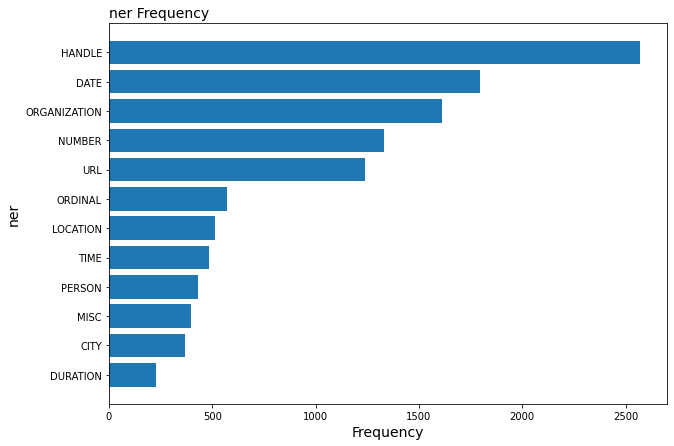

In [24]:
ner = ner_count['ner']
count = ner_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(ner, count)
ax.invert_yaxis()
ax.set_title('ner Frequency',loc ='left', size = 14)
ax.set_ylabel('ner', size = 14)
ax.set_xlabel('Frequency', size = 14)
fig.show()

為了正確計算詞頻，將word轉小寫存新欄位

In [25]:
tokens['word_lower'] = tokens['word'].str.lower()
tokens['lemma_lower'] = tokens['word'].str.lower()
tokens.head(5)

,status_id,word,lemma,pos,ner,word_lower,lemma_lower
0,1439740696974409731,RT,rt,NN,O,rt,rt
1,1439740696974409731,@anitakissee,@anitakissee,NN,HANDLE,@anitakissee,@anitakissee
2,1439740696974409731,:,:,:,O,:,:
3,1439740696974409731,This,this,DT,O,this,this
4,1439740696974409731,is,be,VBZ,O,is,is


### 涉及到的國家(COUNTRY)
+ 透過coreNLP中的NER解析出在Twitter上面談論covid19，所涉及到的國家(COUNTRY)

In [26]:
# 篩選ner為country的資料
country = tokens.loc[tokens['ner'] == 'COUNTRY']

# 計算每個國家提到的次數，選出前13個
country_count = country.groupby('word_lower')['word_lower'].agg(['count'])
country_count = country_count.sort_values(['count'],ascending=False)['count'].nlargest(13).reset_index()
country_count.head(5)

,word_lower,count
0,india,55
1,australia,17
2,china,14
3,u.s.,13
4,israel,9


In [27]:
# 另外一種寫法
country_count = country[['word_lower']].groupby(['word_lower'])['word_lower'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(13)
country_count

,word_lower,count
12,india,55
3,australia,17
6,china,14
27,u.s.,13
14,israel,9
23,states,8
30,united,8
17,namibia,8
11,germany,6
19,pakistan,6


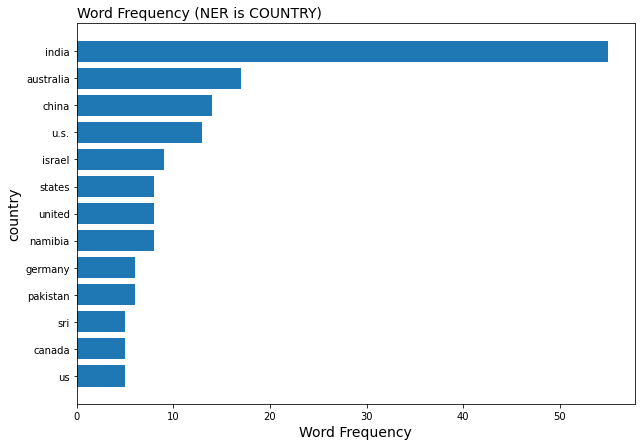

In [28]:
word = country_count['word_lower']
count = country_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is COUNTRY)',loc ='left', size = 14)
ax.set_ylabel('country', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

+ 可以抓取關鍵字貼文，來看看相關的貼文大致在說甚麼，
+ 最常出現的國家依序如下，以下挑出幾個比較特別的事件：
    + 印度: WHO 可能會批准印度的國產疫苗 Covaxin
    + 澳洲: 成為第一個要求進入公共產和需要出示疫苗接種證明的國家
    + 中國: 疫苗接種率高達 71% ，或是其他國家從中國購買疫苗的相關新聞
    + 美國: 各種官方呼籲接種疫苗、配到口罩的相關宣傳    

In [29]:
keyword_list = ['india']
ids = country[country['word_lower'].str.contains('|'.join(keyword_list),regex=True, case=False)].status_id
df = tweets_df[tweets_df['status_id'].isin(ids)]
print(f"{' '.join(keyword_list)}：{df.shape[0]}篇相關貼文")
df.head(3)

india：54篇相關貼文


,created_at,status_id,user_id,user_name,text,favourites,retweet,source
826,2021-09-18 17:40:08,1439283108411428864,Upendra53679590,Upendra Verma,RT @IndiaTVHindi: #WHO is likely to grant appr...,0,2,Twitter for Android
983,2021-09-18 15:45:52,1439254353471287300,Sambad_English,Sambad English,Over 80 crore Covid vaccine doses administered...,13,0,Twitter Web App
1077,2021-09-18 12:48:03,1439209603208675329,sam_06_02,sarla,RT @DDNewslive: #InFocus: India sets new singl...,0,2,Twitter for Android


### 涉及到的組織(ORGANIZATION)
+ 我們可以透過coreNLP中的NER解析出在Twitter上面談論新冠肺炎時，所涉及到的組織(ORGANIZATION)

In [30]:
org = tokens.loc[tokens['ner'] == 'ORGANIZATION']
org_count = org[['word_lower']].groupby(['word_lower'])['word_lower'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(15)
org_count.head(5)

,word_lower,count
63,centre,72
1,&,51
201,pfizer,51
226,scarborough,47
17,ajax,37


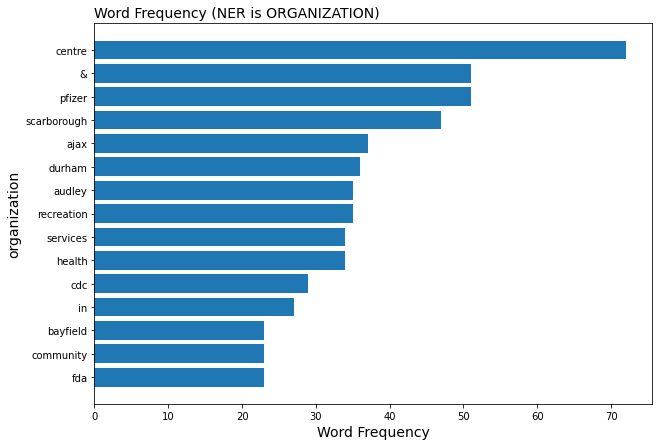

In [31]:
word = org_count['word_lower']
count = org_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is ORGANIZATION)',loc ='left', size = 14)
ax.set_ylabel('organization', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

+ pfizer: 輝瑞製藥公司
+ fda: 美國食品藥物管理局(可能為疫苗相關討論)
+ cdc: Centers for Disease Control and Prevention, 美國疾病管制與預防中心

In [32]:
# 查看特定關鍵字的貼文內容
keyword_list = ['pfizer']
ids = org[org['word_lower'].str.contains('|'.join(keyword_list),regex=True, case=False)].status_id
df = tweets_df[tweets_df['status_id'].isin(ids)]
print(f"{' '.join(keyword_list)}：{df.shape[0]}篇相關貼文")
df.head(3)

pfizer：51篇相關貼文


,created_at,status_id,user_id,user_name,text,favourites,retweet,source
1040,2021-09-18 13:52:06,1439225723919613952,newscenterPHL1,Newscenter PHL,"RT @philstarlife: Over the entire period, the ...",0,17,Twitter for Android
1062,2021-09-18 13:12:08,1439215666184196102,AureliaCotta,Aurelia Cotta,Pfizer - practicing racism towards Africa sinc...,0,0,Twitter for iPhone
1117,2021-09-18 10:38:16,1439176944394723334,ClinicKirei,Tokyo Kirei Clinic,A paper summarizing data on booster vaccinatio...,1,0,Twitter Web App


### 涉及到的人物(PERSON)
+ 我們可以透過coreNLP中的NER解析出在Twitter上面談論新冠肺炎，所涉及到的人物(PERSON)

In [33]:
peo = tokens.loc[tokens['ner'] == 'PERSON']
peo_count = peo[['word_lower']].groupby(['word_lower'])['word_lower'] \
                                         .count() \
                                         .reset_index(name='count') \
                                         .sort_values(['count'], ascending=False) \
                                         .head(10)
peo_count.head(5)

,word_lower,count
89,minaj,20
98,nicki,20
80,maria,18
5,anna,18
70,kildonan,18


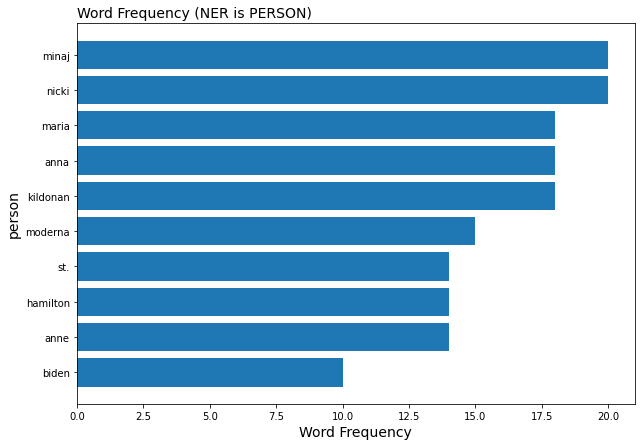

In [34]:
word = peo_count['word_lower']
count = peo_count['count']

fig, ax = plt.subplots(figsize =(10, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 14)
ax.set_ylabel('person', size = 14)
ax.set_xlabel('Word Frequency', size = 14)
fig.show()

+ Nicki Minaj: 美饒舌歌手，對疫苗安全性存疑，引來其他專家批評
+ biden: Joe Biden, 美國總統，呼籲大家接種疫苗

In [35]:
# 查看特定關鍵字的貼文內容
keyword_list = ['Nicki']
ids = peo[peo['word_lower'].str.contains('|'.join(keyword_list),regex=True, case=False)].status_id
df = tweets_df[tweets_df['status_id'].isin(ids)]
print(f"{' '.join(keyword_list)}：{df.shape[0]}篇相關貼文")
df.head(3)

Nicki：20篇相關貼文


,created_at,status_id,user_id,user_name,text,favourites,retweet,source
75,2021-09-19 19:57:55,1439680171032948741,ruthlessbardi,#SurvivingThepettys / i cared about the victim,RT @iamchanteezy: Nicki Minaj should be ashame...,0,48,Twitter for Android
2313,2021-09-16 16:59:14,1438548041854689311,Neoprankster,Alex,RT @iamchanteezy: Nicki Minaj should be ashame...,0,48,Twitter Web App
2316,2021-09-16 16:52:50,1438546429497143296,Neoprankster,Alex,RT @iamchanteezy: Nicki Minaj is setting a dan...,0,77,Twitter Web App


### 3.4 探索分析 - Sentiment
將經過coreNLP處理後的文集，進行情緒分析

In [36]:
# 讀取已經執行完畢的結果
sentiment = pd.read_csv("raw_data/eng/sentiment_covid19vaccine.csv")
sentiment.head(5)

,status_id,word,sentiment
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive
1,1439740696974409731,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral
2,1439739935959912448,RT @anitakissee : This is my favorite #Covid1...,Positive
3,1439739935959912448,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral
4,1439739587694268416,RT @StanfordMed : Allergic reactions to the n...,Positive


In [37]:
# 看有哪些情緒
sentiment['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Very positive'], dtype=object)

In [38]:
# 看一下各情緒的分布
sentiment.groupby('sentiment')['sentiment'].agg(['count'])

,count
sentiment,
Negative,565
Neutral,3348
Positive,599
Very positive,1


In [39]:
# 把時間加到sentiment裡面
tweets_df = pd.read_csv("raw_data/eng/tweets_covid19vaccine.csv") #匯資料
sentiment_date = pd.merge(sentiment, tweets_df[['status_id','created_at','source']], on="status_id", how='left')
sentiment_date.head(5)

,status_id,word,sentiment,created_at,source
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:58:25,Twitter for Android
1,1439740696974409731,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral,2021-09-19 23:58:25,Twitter for Android
2,1439739935959912448,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:55:24,Twitter Web App
3,1439739935959912448,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral,2021-09-19 23:55:24,Twitter Web App
4,1439739587694268416,RT @StanfordMed : Allergic reactions to the n...,Positive,2021-09-19 23:54:01,Twitter for iPhone


In [40]:
# 將情緒轉為分數
def label_sentiment(row):
    if row['sentiment'] == "Very positive" :
        return 2
    if row['sentiment'] == "Positive" :
        return 1
    if row['sentiment'] == "Neutral" :
        return 0
    if row['sentiment'] == "Negative" :
        return -1

In [41]:
sentiment_date['sentimentValue'] = sentiment_date.apply(lambda row: label_sentiment(row), axis=1)
sentiment_date.head(3)

,status_id,word,sentiment,created_at,source,sentimentValue
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:58:25,Twitter for Android,1
1,1439740696974409731,https://t.co/g4VvHPIX1f https://t.co/AdzdVE2sBe,Neutral,2021-09-19 23:58:25,Twitter for Android,0
2,1439739935959912448,RT @anitakissee : This is my favorite #Covid1...,Positive,2021-09-19 23:55:24,Twitter Web App,1


+ 平均情緒分數時間趨勢

In [42]:
# 轉換時間格式為天
sentiment_date['created_at'] =  pd.to_datetime(sentiment_date['created_at']).dt.date
sentiment_count = sentiment_date.groupby(['created_at'])['sentimentValue'].mean().reset_index()
sentiment_count

,created_at,sentimentValue
0,2021-09-15,-0.215385
1,2021-09-16,-0.002483
2,2021-09-17,0.025522
3,2021-09-18,0.040650
4,2021-09-19,0.051209


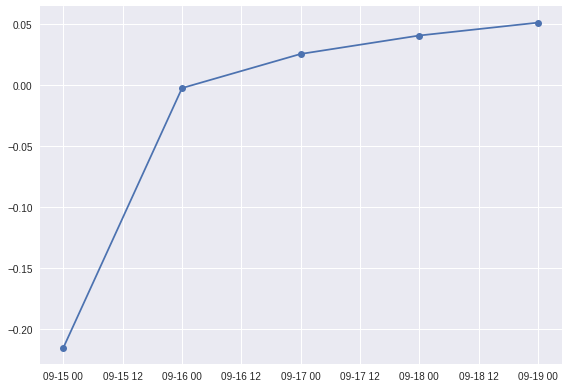

In [43]:
# 平均情緒分數時間趨勢
plt.style.use('seaborn')

dates = sentiment_count['created_at']
y = sentiment_count['sentimentValue']

plt.plot_date(dates, y, linestyle='solid')
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.show()

## 不同用戶端情緒時間趨勢

In [44]:
# 篩出安卓和蘋果的用戶
sentiment_source = sentiment_date[sentiment_date['source'].isin(['Twitter for Android', 'Twitter for iPad'])]
# 算每天的情緒
source_count = sentiment_source.groupby(['created_at','source'])['sentimentValue'].mean().reset_index()
source_count

,created_at,source,sentimentValue
0,2021-09-15,Twitter for Android,-0.276316
1,2021-09-15,Twitter for iPad,-0.090909
2,2021-09-16,Twitter for Android,0.127090
3,2021-09-16,Twitter for iPad,-0.195122
4,2021-09-17,Twitter for Android,0.037313
5,2021-09-17,Twitter for iPad,0.111111
6,2021-09-18,Twitter for Android,0.086643
7,2021-09-18,Twitter for iPad,0.068966
8,2021-09-19,Twitter for Android,0.107692
9,2021-09-19,Twitter for iPad,0.074074


In [45]:
# spread the column
source_pivot = source_count.pivot_table(index=['created_at'],columns='source',values='sentimentValue',fill_value=0).reset_index()
source_pivot

source,created_at,Twitter for Android,Twitter for iPad
0,2021-09-15,-0.276316,-0.090909
1,2021-09-16,0.127090,-0.195122
2,2021-09-17,0.037313,0.111111
3,2021-09-18,0.086643,0.068966
4,2021-09-19,0.107692,0.074074


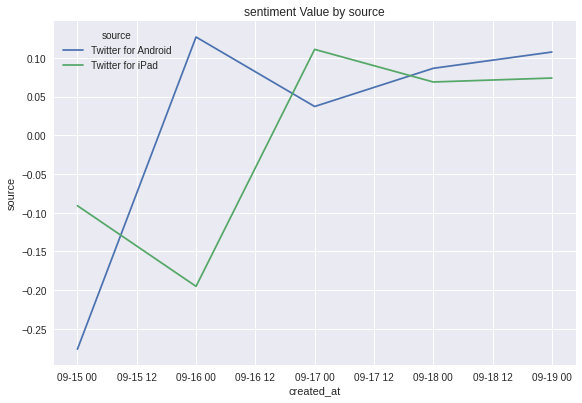

In [46]:
# 不同裝置情緒分數時間趨勢
plt.style.use('seaborn')

source_pivot.plot(x="created_at", y=["Twitter for Android", "Twitter for iPad"])
plt.gcf().autofmt_xdate
plt.tight_layout()

plt.ylabel('sentiment Value')
plt.ylabel('source')
plt.title('sentiment Value by source')

plt.show()

### 正面詞彙探索
把正面文章挑出來，看看他們都用甚麼詞

In [47]:
# 挑出正面詞彙
positive = sentiment[sentiment['sentiment'].isin(['Positive', 'Verypositive'])] # 881
positive_words = pd.merge(positive,tokens,on='status_id',how='left')
positive_words.head(3)

,status_id,word_x,sentiment,word_y,lemma,pos,ner,word_lower,lemma_lower
0,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,RT,rt,NN,O,rt,rt
1,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,@anitakissee,@anitakissee,NN,HANDLE,@anitakissee,@anitakissee
2,1439740696974409731,RT @anitakissee : This is my favorite #Covid1...,Positive,:,:,:,O,:,:


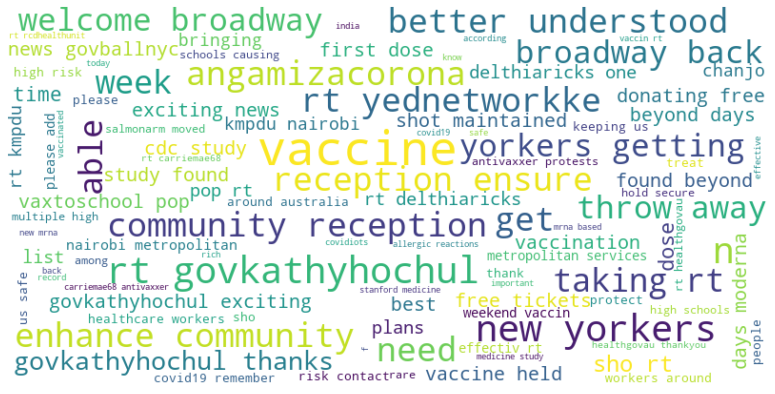

In [48]:
# 匯入預設的stop words 也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["co", "covid19vaccine","https","covid","tweeting"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=50, max_words=100,width=800, height = 400, background_color="white")\
                .generate(' '.join(positive_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

正面情緒部分來自於鼓勵接種的貼文，如紐約人「New Yorkers」接種疫苗「vaccine」可獲得$100美金，或者是解釋為甚麼接種疫苗，比直接染疫可以讓人產生更佳「better」的抗體。

In [49]:
# 挑出負面詞彙
negative = sentiment[sentiment['sentiment'].isin(['Negative', 'Verynegative'])] # 881
negative_words = pd.merge(negative,tokens,on='status_id',how='left')
negative_words.head(3)

,status_id,word_x,sentiment,word_y,lemma,pos,ner,word_lower,lemma_lower
0,1439736173614620672,If you refuse to get vaccinated and insist on...,Negative,If,if,IN,O,if,if
1,1439736173614620672,If you refuse to get vaccinated and insist on...,Negative,you,you,PRP,O,you,you
2,1439736173614620672,If you refuse to get vaccinated and insist on...,Negative,refuse,refuse,VBP,O,refuse,refuse


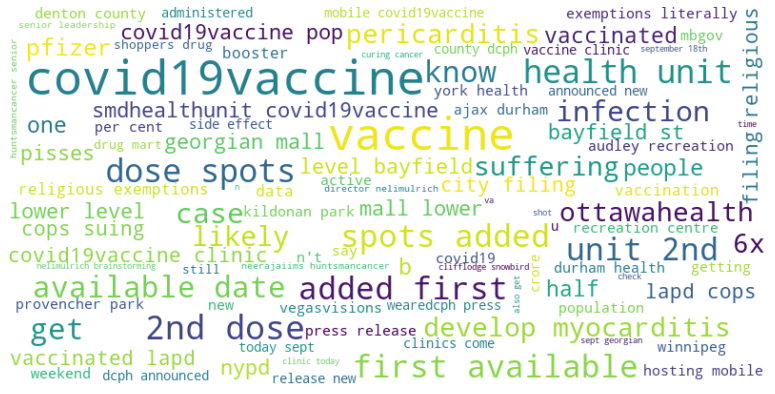

In [50]:
# 匯入預設的stop words 也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["co","rt", "https","covid"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=50, max_words=100,width=800, height = 400, background_color="white")\
                .generate(' '.join(negative_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (14,7))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面貼文部分和疫苗的處置相關，如有媒體認為經濟能力較差的國家不應該成為次級疫苗「COVID19Vaccine」試劑「doses」的傾倒場。或是警告比起負擔「suffering」疫苗的副作用，直接染疫的風險更大。如罹患心肌炎「myocarditis」的地風險會增加。

## 4. TextBlob

+ 除了coreNLP 還有一些比較簡單的套件可以處理文字，在這裡介紹textBlob，https://github.com/sloria/TextBlob
+ 情緒計算
    + polarity > 0 是正面的字，反之是負面的
    + subjectivity 代表有多主觀
+ 第一步我們先把正負面的貼文挑出來，然後再看看通常正負面的貼文都用什麼樣的字

In [51]:
from textblob import TextBlob
# 獲得一個句子的正負面情緒
testimonial = TextBlob("Textblob is amazingly simple to use. What great fun!")
testimonial.sentiment

Sentiment(polarity=0.39166666666666666, subjectivity=0.4357142857142857)

In [52]:
def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment.polarity
    except:
        return None

tweets_df['polarity'] = tweets_df['text'].apply(sentiment_calc)
tweets_df.head(3)

,created_at,status_id,user_id,user_name,text,favourites,retweet,source,polarity
0,2021-09-19 23:58:25,1439740696974409731,MPsLife,🐧 MP 🇺🇸,RT @anitakissee: This is my favorite #Covid19v...,0,4,Twitter for Android,0.392857
1,2021-09-19 23:55:24,1439739935959912448,AvgeekJoe,"joe a. kanzlar, VACCINATED & PLEASE BE VAXXED ...",RT @anitakissee: This is my favorite #Covid19v...,0,4,Twitter Web App,0.392857
2,2021-09-19 23:54:01,1439739587694268416,s_anand1,S.Anand,RT @StanfordMed: Allergic reactions to the new...,0,23,Twitter for iPhone,0.218182


In [53]:
# 挑出正負面情緒
positive = tweets_df.loc[tweets_df['polarity'] > 0][['status_id','polarity']]
negative = tweets_df.loc[tweets_df['polarity'] < 0][['status_id','polarity']]

In [54]:
# 去除停用字和標點符號
stop_words = set(stopwords.words('english'))
filter_tokens = tokens[~tokens.word.isin(list(stop_words))] # 82548 => 63024
filter_tokens = filter_tokens[filter_tokens.lemma_lower.str.isalpha()] # 63024 => 36778

In [55]:
filter_tokens

,status_id,word,lemma,pos,ner,word_lower,lemma_lower
0,1439740696974409731,RT,rt,NN,O,rt,rt
3,1439740696974409731,This,this,DT,O,this,this
6,1439740696974409731,favorite,favorite,JJ,O,favorite,favorite
8,1439740696974409731,video,video,NN,O,video,video
10,1439740696974409731,TikTok,TikTok,NNP,O,tiktok,tiktok
...,...,...,...,...,...,...,...
72163,1438181781564493824,September,September,NNP,DATE,september,september
72167,1438181781564493824,Canadian,canadian,JJ,NATIONALITY,canadian,canadian
72168,1438181781564493824,Mental,Mental,NNP,O,mental,mental
72169,1438181781564493824,Health,Health,NNP,O,health,health


In [56]:
positive_words = pd.merge(positive,filter_tokens[['status_id','lemma_lower']],on='status_id',how='left')
negative_words = pd.merge(negative,filter_tokens[['status_id','lemma_lower']],on='status_id',how='left')

看一下正面的句子都用甚麼樣的詞

In [57]:
positive_words.groupby(['lemma_lower'])['lemma_lower'] \
                         .count() \
                         .reset_index(name='count') \
                         .sort_values(['count'], ascending=False) \
                         .head(10)

,lemma_lower,count
1352,rt,1229
373,covid,718
966,medical,477
898,list,473
873,leaders,473
551,experts,472
605,following,471
185,black,470
818,interested,470
1623,trustworthy,469


In [58]:
# 看一下負面的都是甚麼字
negative_words.groupby(['lemma_lower'])['lemma_lower'] \
                         .count() \
                         .reset_index(name='count') \
                         .sort_values(['count'], ascending=False) \
                         .head(10)

,lemma_lower,count
673,rt,154
123,clinics,43
847,vaccine,42
796,today,40
592,pm,39
158,covid,35
785,this,32
563,park,31
335,health,30
579,people,27


## 結論
分析主題：2021-09-15 到 2021-09-20　期間，推特上各國對於covid 19的新聞大事件

#### 1. 推特上討論疫苗的國家/組織/名人主要有哪些，發生了甚麼重要事件？
+ 主要國家
    + 印度: WHO 可能會批准印度的國產疫苗 Covaxin
    + 澳洲: 成為第一個要求進入公共產和需要出示疫苗接種證明的國家
    + 中國: 疫苗接種率高達 71% ，或是其他國家從中國購買疫苗的相關新聞
    + 美國: 各種官方呼籲接種疫苗、配到口罩的相關宣傳
+ 主要組織
    + pfizer: (輝瑞製藥)、fda(美國食品藥物管理局)、cdc(美國疾病管制與預防中心)
+ 主要名人：
    + Nicki Minaj: 美饒舌歌手，對疫苗安全性存疑，引來其他專家批評
    + biden: Joe Biden, 美國總統，呼籲大家接種疫苗

#### 2. 推特上討論疫苗文章情緒分布的趨勢如何，正面和負面的文章主要的討論焦點?
+ 安卓和蘋果的用戶情緒值皆偏低，但在2021-09-15 到 2021-09-20有逐漸升高的趨勢
+ 正面貼文
    + 相關的關鍵字有：New Yorkers、better
    + 正面情緒部分來自於鼓勵接種的貼文，如紐約人「New Yorkers」接種疫苗「vaccine」可獲得100美金，或者是解釋為甚麼接種疫苗，比直接染疫可以讓人產生更佳「better」的抗體。

+ 負面貼文
    + 相關的關鍵字有：doses、suffering、myocarditis
    + 主要和疫苗的處置相關，如有媒體認為經濟能力較差的國家不應該成為次級疫苗「COVID19Vaccine」試劑「doses」的傾倒場。或是警告比起負擔「suffering」疫苗的副作用，直接染疫的風險更大。如罹患心肌炎「myocarditis」的地風險會增加。

### 補充：其他英文處理套件

#### emoji
+  emoji 轉英文字

In [59]:
# %pip install emoji

In [60]:
# emoji to text
import emoji 
print(emoji.demojize('Python is 👍'))

Python is :thumbs_up:


#### vaderSentiment
+ 分析英文句子情緒

In [61]:
# %pip install vaderSentiment

In [62]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

# --- examples -------
sentences = ["VADER is smart, handsome, and funny.",  # positive sentence example
             "VADER is smart, handsome, and funny!",  # punctuation emphasis handled correctly (sentiment intensity adjusted)
             "At least it isn't a horrible book.",  # negated negative sentence with contraction
             "The book was only kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
             "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
             "Today SUX!",  # negative slang with capitalization emphasis
             "Today only kinda sux! But I'll get by, lol", # mixed sentiment example with slang and constrastive conjunction "but"
             "Make sure you :) or :D today!",  # emoticons handled
             "Catch utf-8 emoji such as such as 💘 and 💋 and 😁",  # emojis handled
             "Not bad at all"  # Capitalized negation
             ]

analyzer = SentimentIntensityAnalyzer()
for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

VADER is smart, handsome, and funny.----------------------------- {'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!----------------------------- {'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
At least it isn't a horrible book.------------------------------- {'neg': 0.0, 'neu': 0.678, 'pos': 0.322, 'compound': 0.431}
The book was only kind of good.---------------------------------- {'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'compound': 0.3832}
The plot was good, but the characters are uncompelling and the dialog is not great. {'neg': 0.327, 'neu': 0.579, 'pos': 0.094, 'compound': -0.7042}
Today SUX!------------------------------------------------------- {'neg': 0.779, 'neu': 0.221, 'pos': 0.0, 'compound': -0.5461}
Today only kinda sux! But I'll get by, lol----------------------- {'neg': 0.127, 'neu': 0.556, 'pos': 0.317, 'compound': 0.5249}
Make sure you :) or :D today!------------------------------------ {'neg': 0.0, 'neu': 0.

#### sentimentpy
+ github: https://github.com/trinker/sentimentpy
+ 請用這種方式安裝 `pip install git+https://github.com/trinker/sentimentpy`

In [63]:
# %pip install git+https://github.com/trinker/sentimentpy

In [64]:
# 把句子斷開，去除結尾空白符號
import sentimentpy.split_sentences as ss

s = [
    'I like carrots too mrs. dunbar. Well let\'s go to 100th st. around the corner.   ',
    'Hello Dr. Livingstone.  How are you?',
    'This is sill an incomplete thou.'
]

ss.split_sentences(s)

/usr/local/anaconda3/envs/test/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


['I like carrots too mrs. dunbar.',
 "Well let's go to 100th st. around the corner.",
 'Hello Dr. Livingstone.',
 'How are you?',
 'This is sill an incomplete thou.']

### 相關參考連結
+ 相關文件
    + coreNLP
        + CoreNLPClient parameter
        + https://stanfordnlp.github.io/stanza/client_properties.html
    + tweetpy
        + API.search
        + https://docs.tweepy.org/en/v3.5.0/api.html#help-methods
        + API.search input output
        + https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets

+ 參考code
    + 抓取twitter table
    + https://amandeepsaluja.com/getting-twitter-keyword-data-in-table-format-using-python/